In [7]:
video_game_genres = [
    "Action games", "Action-adventure games", "Adventure games", "Art games", "Aviation video games", 
    "Battle royale games", "Beat 'em ups", 
    "Construction and management simulation games", 
    "Digital tabletop games", "Dress-up video games", 
    "Educational video games", "Eroge", 
    "Fighting games", 
    "Hack and slash games", "Health video games", "Horror video games", 
    "Immersive sims", "Incremental games", "Interactive movie video games", 
    "Martial arts video games", "Metroidvania games", "Music video games", "Mystery video games", 
    "Neo-noir video games", "Non-games", 
    "Open-world video games", 
    "Party video games", "Pinball video games", "Platformers", "Psychological horror games", "Puzzle video games", 
    "Quiz video games", 
    "Racing video games", "Roguelike video games", "Role-playing video games", 
    "Sandbox games", "Shooter games", "Simulation video games", "Social deduction video games", "Soulslike video games", "Sports video games", "Stealth video games", "Strategy video games", "Survival horror video games", "Survival video games", 
    "Tactical role-playing video games", "Typing video games", 
    "Vehicle-building video games"
]


In [8]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import json
import os
from  collections import Counter

import pickle

In [9]:
from IPython.display import display, Markdown
from enum import Enum
import matplotlib.pyplot as plt

SEED = 1234 # Seed for randomizing methods where relevant

class PrintType(Enum):
    SOLUTION = "✅ Solution"
    GRAPH = "📊 Graph"
    COMMENT = "💬 Comment"
    ERROR = "❌ Error"

def printmd(type, string):
    prefix = type.value
    display(Markdown(f"> **{prefix}**: {string}"))


In [10]:
def get_or_create_value(function_to_apply, file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the value from the file
        with open(file_path, 'r') as file:
            value = json.load(file)
    else:
        # Call the function to create the value
        value = function_to_apply()
        # Save the value to the file
        with open(file_path, 'w') as file:
            json.dump(value, file)
    
    return value

game_data = get_or_create_value(lambda: {}, "../data/game_data_with_vader_sentiment.json")

In [11]:
game_data['Bertie the Brain'].keys()

dict_keys(['text', 'categorie', 'title', 'url', 'outpages', 'categories', 'country of development', 'sentiment'])

In [12]:
game_data['Spider-Man 2 (2004 video game)']['categories']

['2004 video games',
 'Action games',
 'Activision games',
 'Game Boy Advance games',
 'GameCube games',
 'N-Gage games',
 'Nintendo DS games',
 'PlayStation 2 games',
 'PlayStation Portable games',
 'Sony Pictures video games',
 'Treyarch games',
 'Video game sequels',
 'Video games based on films',
 'Video games based on Spider-Man films',
 'Video games based on adaptations',
 'Video games scored by Yannis Brown',
 'Video games set in New York City',
 'Video games with alternative versions',
 'Windows games',
 'Xbox games',
 'Open-world video games',
 'Aspyr games',
 'Spider-Man (2002 film series)',
 'Digital Eclipse games',
 'Single-player video games',
 'Video games developed in the United States',
 'The Fizz Factor games',
 'Vicarious Visions games']

In [15]:
# Get year property
selected_attributes = ['outpages', 'year', 'country of development', 'sentiment', 'genres']
categorie = []
new_game_data = dict()
for g in game_data:
    new_game_data[g] = dict()
    new_game_data[g]['outpages'] = game_data[g]['outpages']
    new_game_data[g]['year'] = int(game_data[g]['categorie'].split(' ')[0])
    new_game_data[g]['country of development'] = game_data[g]['country of development']
    new_game_data[g]['sentiment'] = game_data[g]['sentiment']
    new_game_data[g]['genres'] = [el for el in game_data[g]['categories'] if el in video_game_genres]
    

In [17]:
import networkx as nx

def create_directed_graph(data, selected_attributes = []):
    # Create a directed graph
    G = nx.DiGraph()
    # Iterate over dictionary items
    for node, properties in data.items():
        selected_attributes_dict = dict()
        for att in selected_attributes:
            selected_attributes_dict[att] = properties[att]
        # Add the node to the graph
        G.add_node(node, **selected_attributes_dict)
        # Add edges from this node to each node in 'outpages'
        for outpage in properties.get('outpages', []):
            G.add_edge(node, outpage)

    return G

In [18]:
G = create_directed_graph(new_game_data, selected_attributes)

In [40]:
G.nodes

NodeView(('Bertie the Brain', 'Marienbad (video game)', 'Super Mario Bros.', 'Puszka Pandory', 'Tajemnica Statuetki', 'Spacewar!', 'Galaxy Game', 'Computer Space', 'Space Wars', 'Space War', 'Star Control', 'The Sumerian Game', 'Santa Paravia en Fiumaccio', 'Hamurabi (video game)', 'M.U.L.E.', 'Space Travel (video game)', 'Pong', 'Space Invaders', 'Star Trek (1971 video game)', 'Stellar Track', 'Trek-80', 'Trek73', 'Video Trek 88', 'Star Fleet I: The War Begins', 'Star Raiders', 'The Oregon Trail (1971 video game)', 'The Yukon Trail', 'The Amazon Trail', 'Empire (1972 video game)', 'Video Olympics', 'Arcade Classics', 'Retro Atari Classics', 'TD Overdrive: The Brotherhood of Speed', 'Arkanoid', "Break 'Em All", 'Pong: The Next Level', 'Banjo-Kazooie: Nuts & Bolts', 'Empire (1973 video game)', 'Netrek', 'Galactic Attack', 'Gotcha (video game)', 'Hunt the Wumpus', 'Lemonade Stand', 'Lemonade Tycoon', 'Maze (1973 video game)', 'Spasim', 'Catacomb 3-D', 'MIDI Maze', 'Space Race (video game

In [41]:
print(len(G))
print(len(G.edges))

18823
33989


In [19]:
# import pickle

# # save graph object to file
pickle.dump(G, open('../data/graph.pickle', 'wb'))

In [2]:
import pickle

# Load graph object from pickle file that we saved in lecture 4
G = pickle.load(open('../data/graph.pickle', 'rb'))

Number of Nodes: 18823
Number of Edges: 33989
Average Degree: 3.61


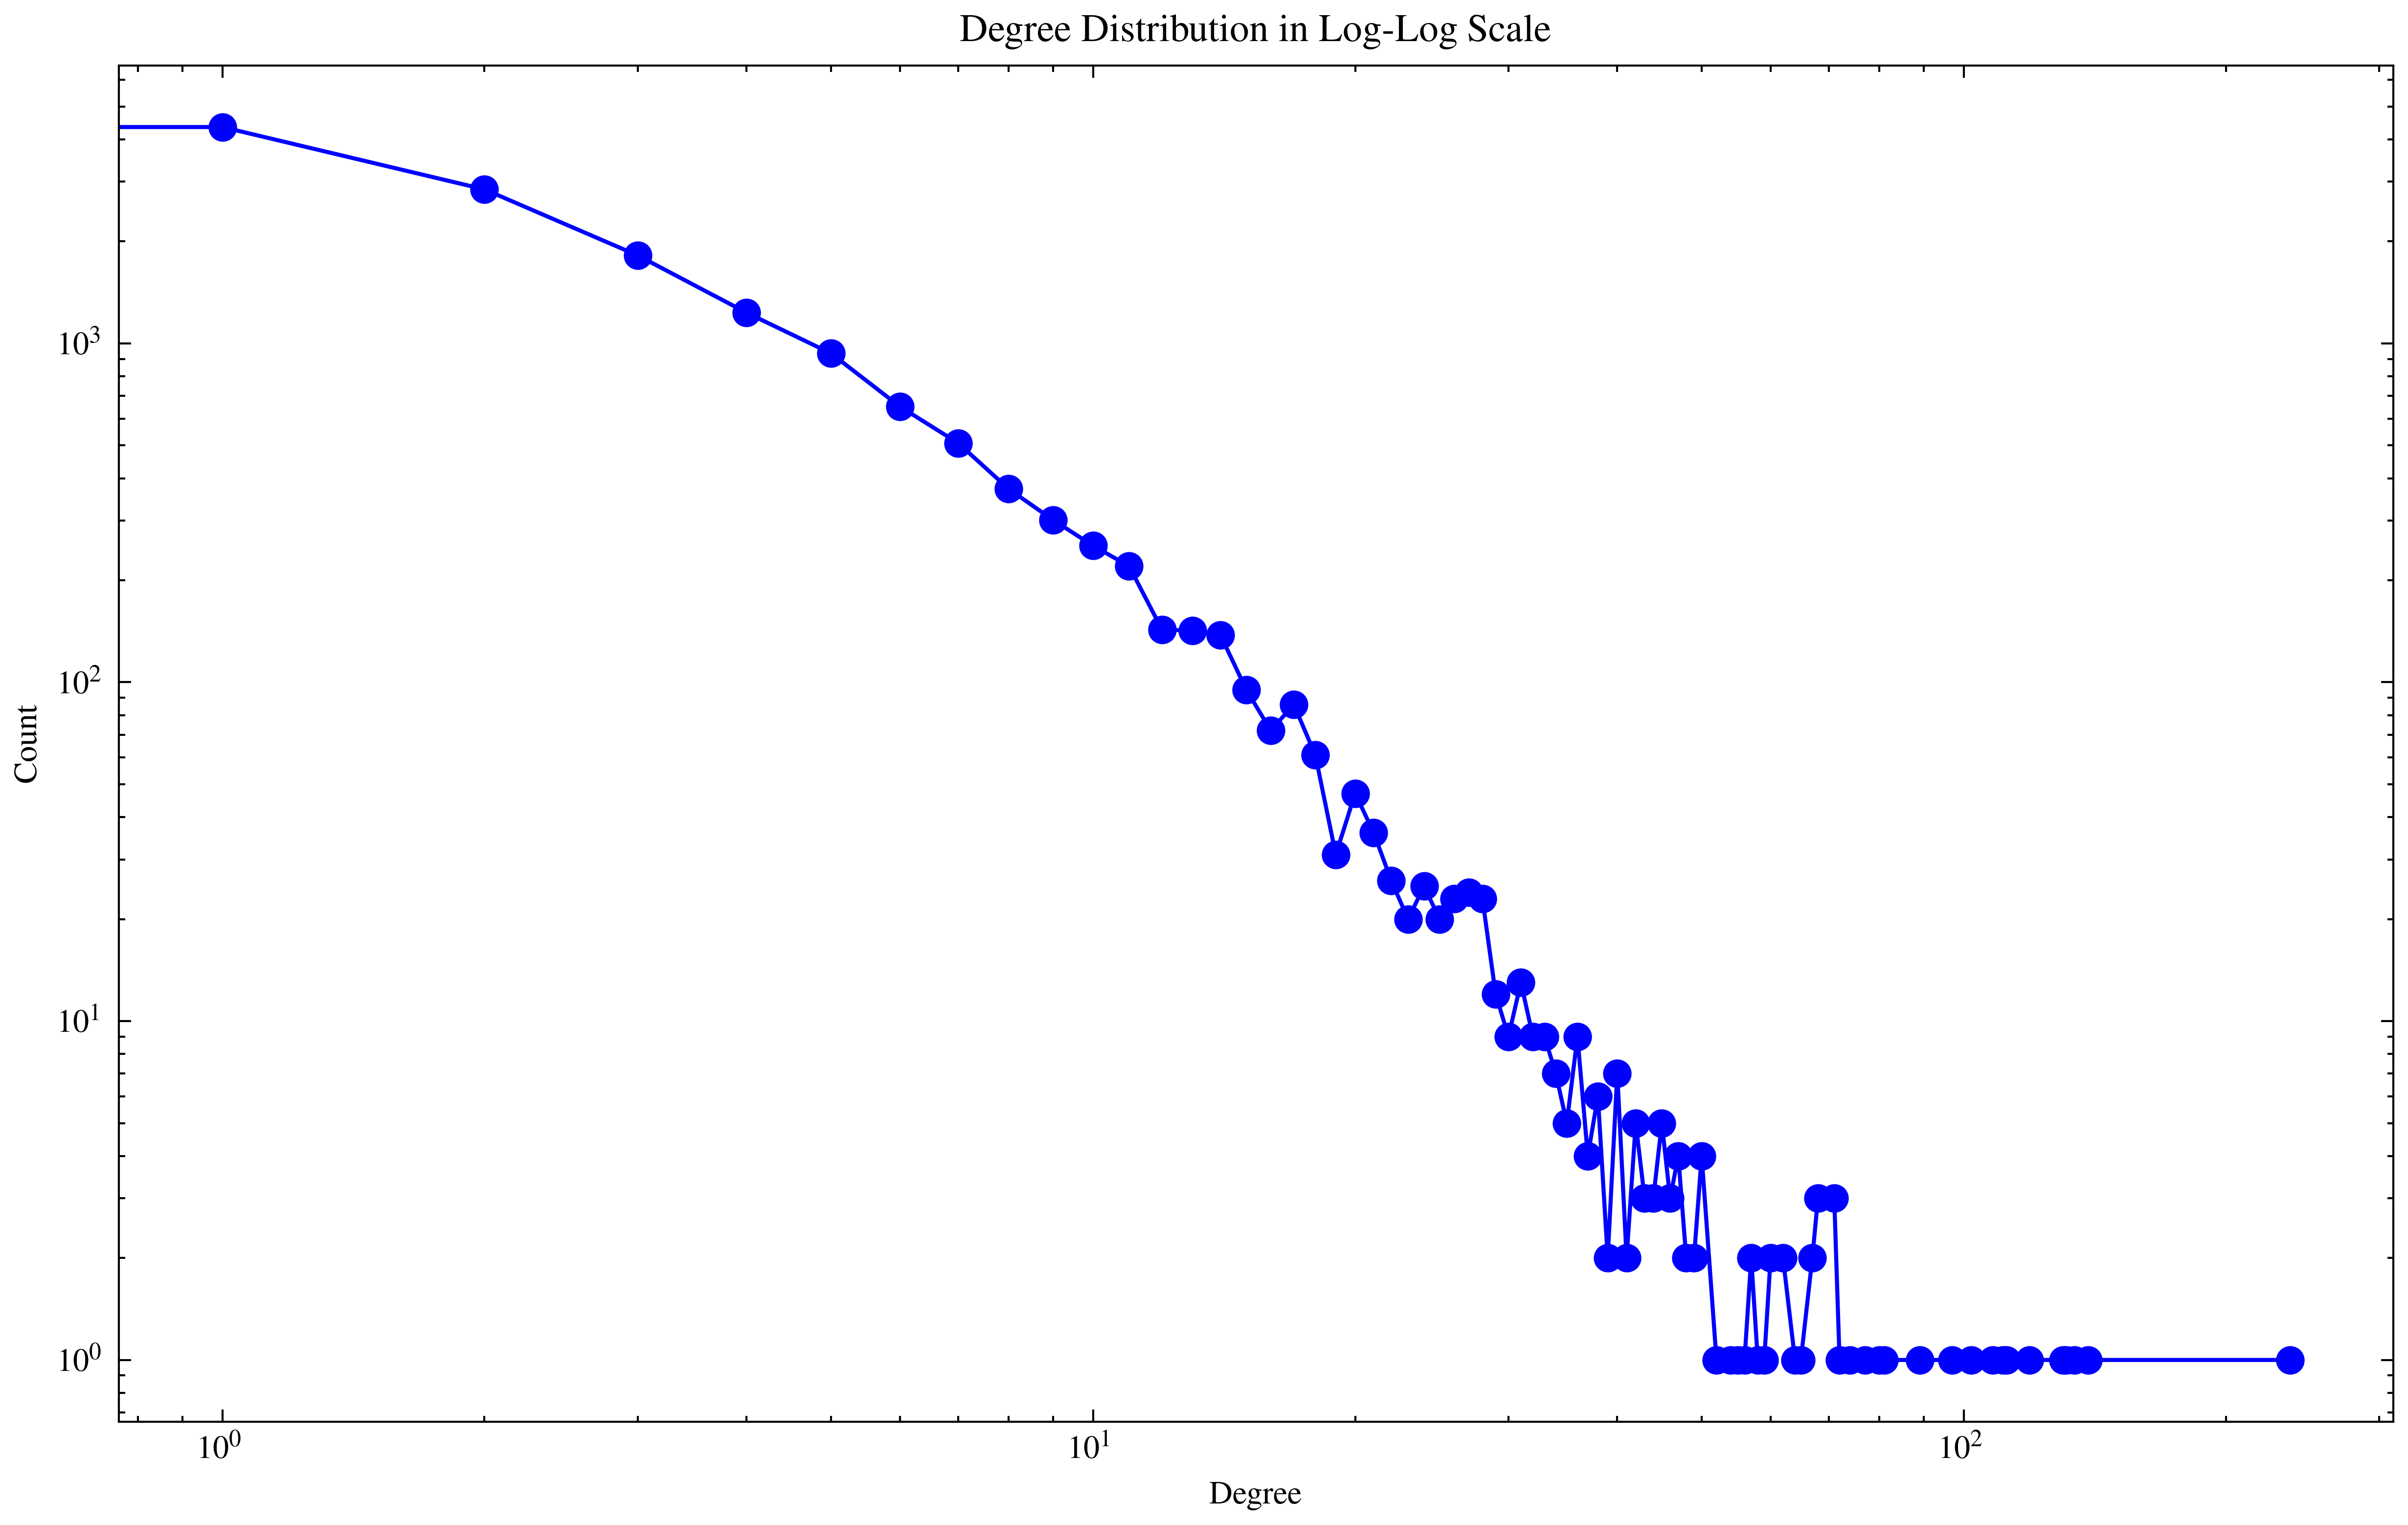

Graph Density: 0.0001


In [3]:

from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

# Assuming G is your graph

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")

# Average degree
avg_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Average Degree: {avg_degree:.2f}")

# Degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.loglog(deg, cnt, 'bo-')  # use loglog scale and change from bar to scatter plot
plt.title("Degree Distribution in Log-Log Scale")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

# Graph density
density = nx.density(G)
print(f"Graph Density: {density:.4f}")


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def degree_distribution_plot(d1, label1, d2, label2, title="", n_bins = 100, xscale="linear", yscale = "linear", figsize = (15,7), fig = None, ax = None):
    # Convert input lists to Python lists
    d1 = list(d1)
    d2 = list(d2)

    # Create bins for the histogram using numpy's linspace function
    # The bins range from the minimum to the maximum of the combined d1 and d2 lists
    bins = np.linspace(min(d1+d2), max(d1+d2), n_bins)
    
    # Use numpy's histogram function to calculate the frequency and bin edges for d1 and d2
    frq1, edges1 = np.histogram(a=d1, bins=bins)
    frq2, edges2 = np.histogram(a=d2, bins=bins)

    # If no figure or axis is provided, create a new one
    if(fig == None and ax == None):
        fig, ax = plt.subplots(1, 1)

    # If a title is provided, set it as the figure's title
    if(title != ""):
        fig.suptitle(title, fontsize=16)

    # Set the figure's height and width
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    # Plot the histogram for d1 and d2
    if(xscale=="linear" and yscale=="linear"):
        ax.hist(edges1[:-1], n_bins, weights=frq1, label=label1, alpha = 0.7, lw=2)
        ax.hist(edges2[:-1], n_bins, weights=frq2, label=label2, alpha = 0.7, lw=2)
    else:
        ax.plot(bins[:-1], frq1, marker="o", linestyle = 'none', label=label1, alpha = 0.7)
        ax.plot(bins[:-1], frq2, marker="o", linestyle = 'none', label=label2, alpha = 0.7)
    # Set labels for the x and y axes
    ax.set_xlabel("k")
    ax.set_ylabel("count")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
 
    # Add a legend to the plot
    ax.legend()

    # Hide the bottom spine of the plot
    ax.spines['bottom'].set_visible(False)

    return bins


In [14]:
import powerlaw
in_alpha = powerlaw.Fit(list(dict(G.in_degree).values())).alpha
out_alpha = powerlaw.Fit(list(dict(G.out_degree).values())).alpha
total_alpha = powerlaw.Fit(list(dict(G.degree).values())).alpha

printmd(PrintType.SOLUTION, f'''Exponents of the degree distribution:
>    * In: {in_alpha:.2f}
>    * Out: {out_alpha:.2f}
>    * Total: {total_alpha:.2f}
''')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


> **✅ Solution**: Exponents of the degree distribution:
>    * In: 3.24
>    * Out: 7.67
>    * Total: 3.63


(0.8, 61732.63624235111)

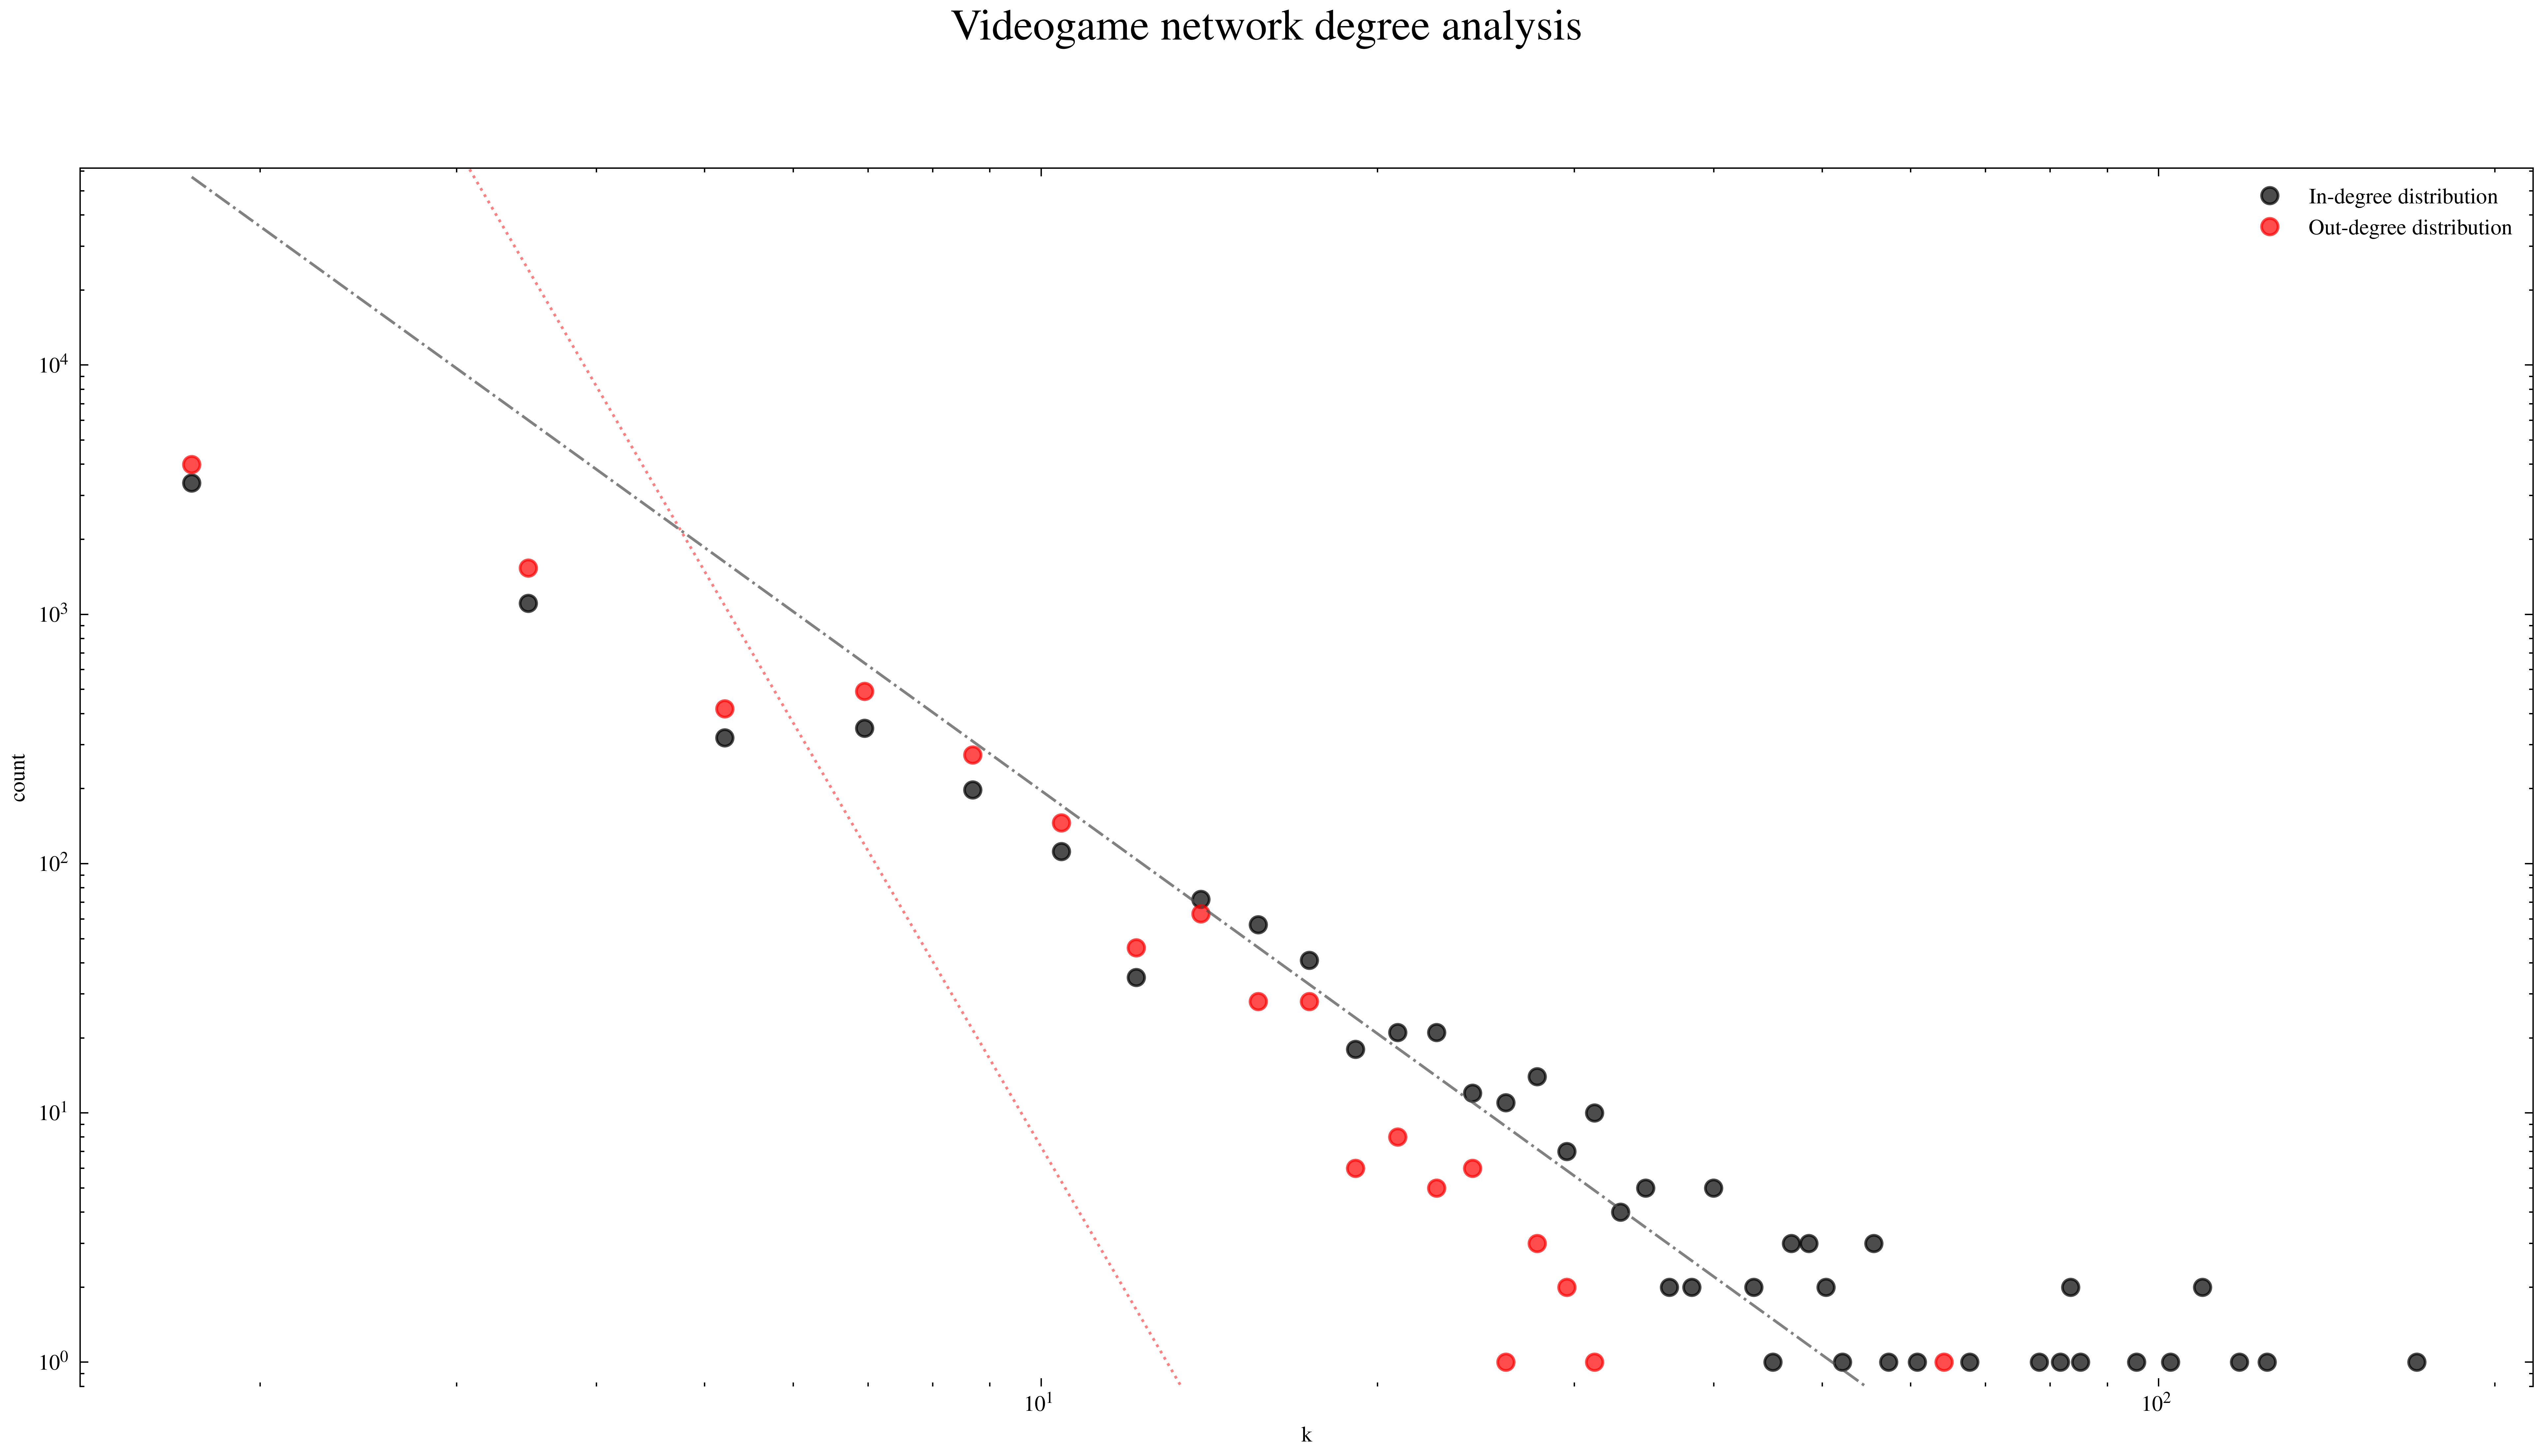

In [13]:
fig, (ax1) = plt.subplots(1, 1)

# Compare each plot
bins = degree_distribution_plot(dict(G.in_degree).values(), "In-degree distribution", 
    dict(G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis', n_bins=100, figsize=(16,8), fig = fig, ax=ax1
    , xscale="log", yscale="log"
    )

N = sum(dict(G.in_degree).values())

def get_powerlaw(k, alpha):
    return N*(k**-alpha)

def f(x, y):
   return N*np.sin(x)
bins = bins[1:]
ax1.plot(bins, get_powerlaw(bins, out_alpha)*100000, color="#ff4c4c", alpha=0.7)
ax1.plot(bins, get_powerlaw(bins, in_alpha)*10, color="#4c4c4c", alpha=0.7)
ax1.set_ylim(0.8,max(get_powerlaw(bins, out_alpha) + get_powerlaw(bins, in_alpha))*10)



(0.0, 25.0)

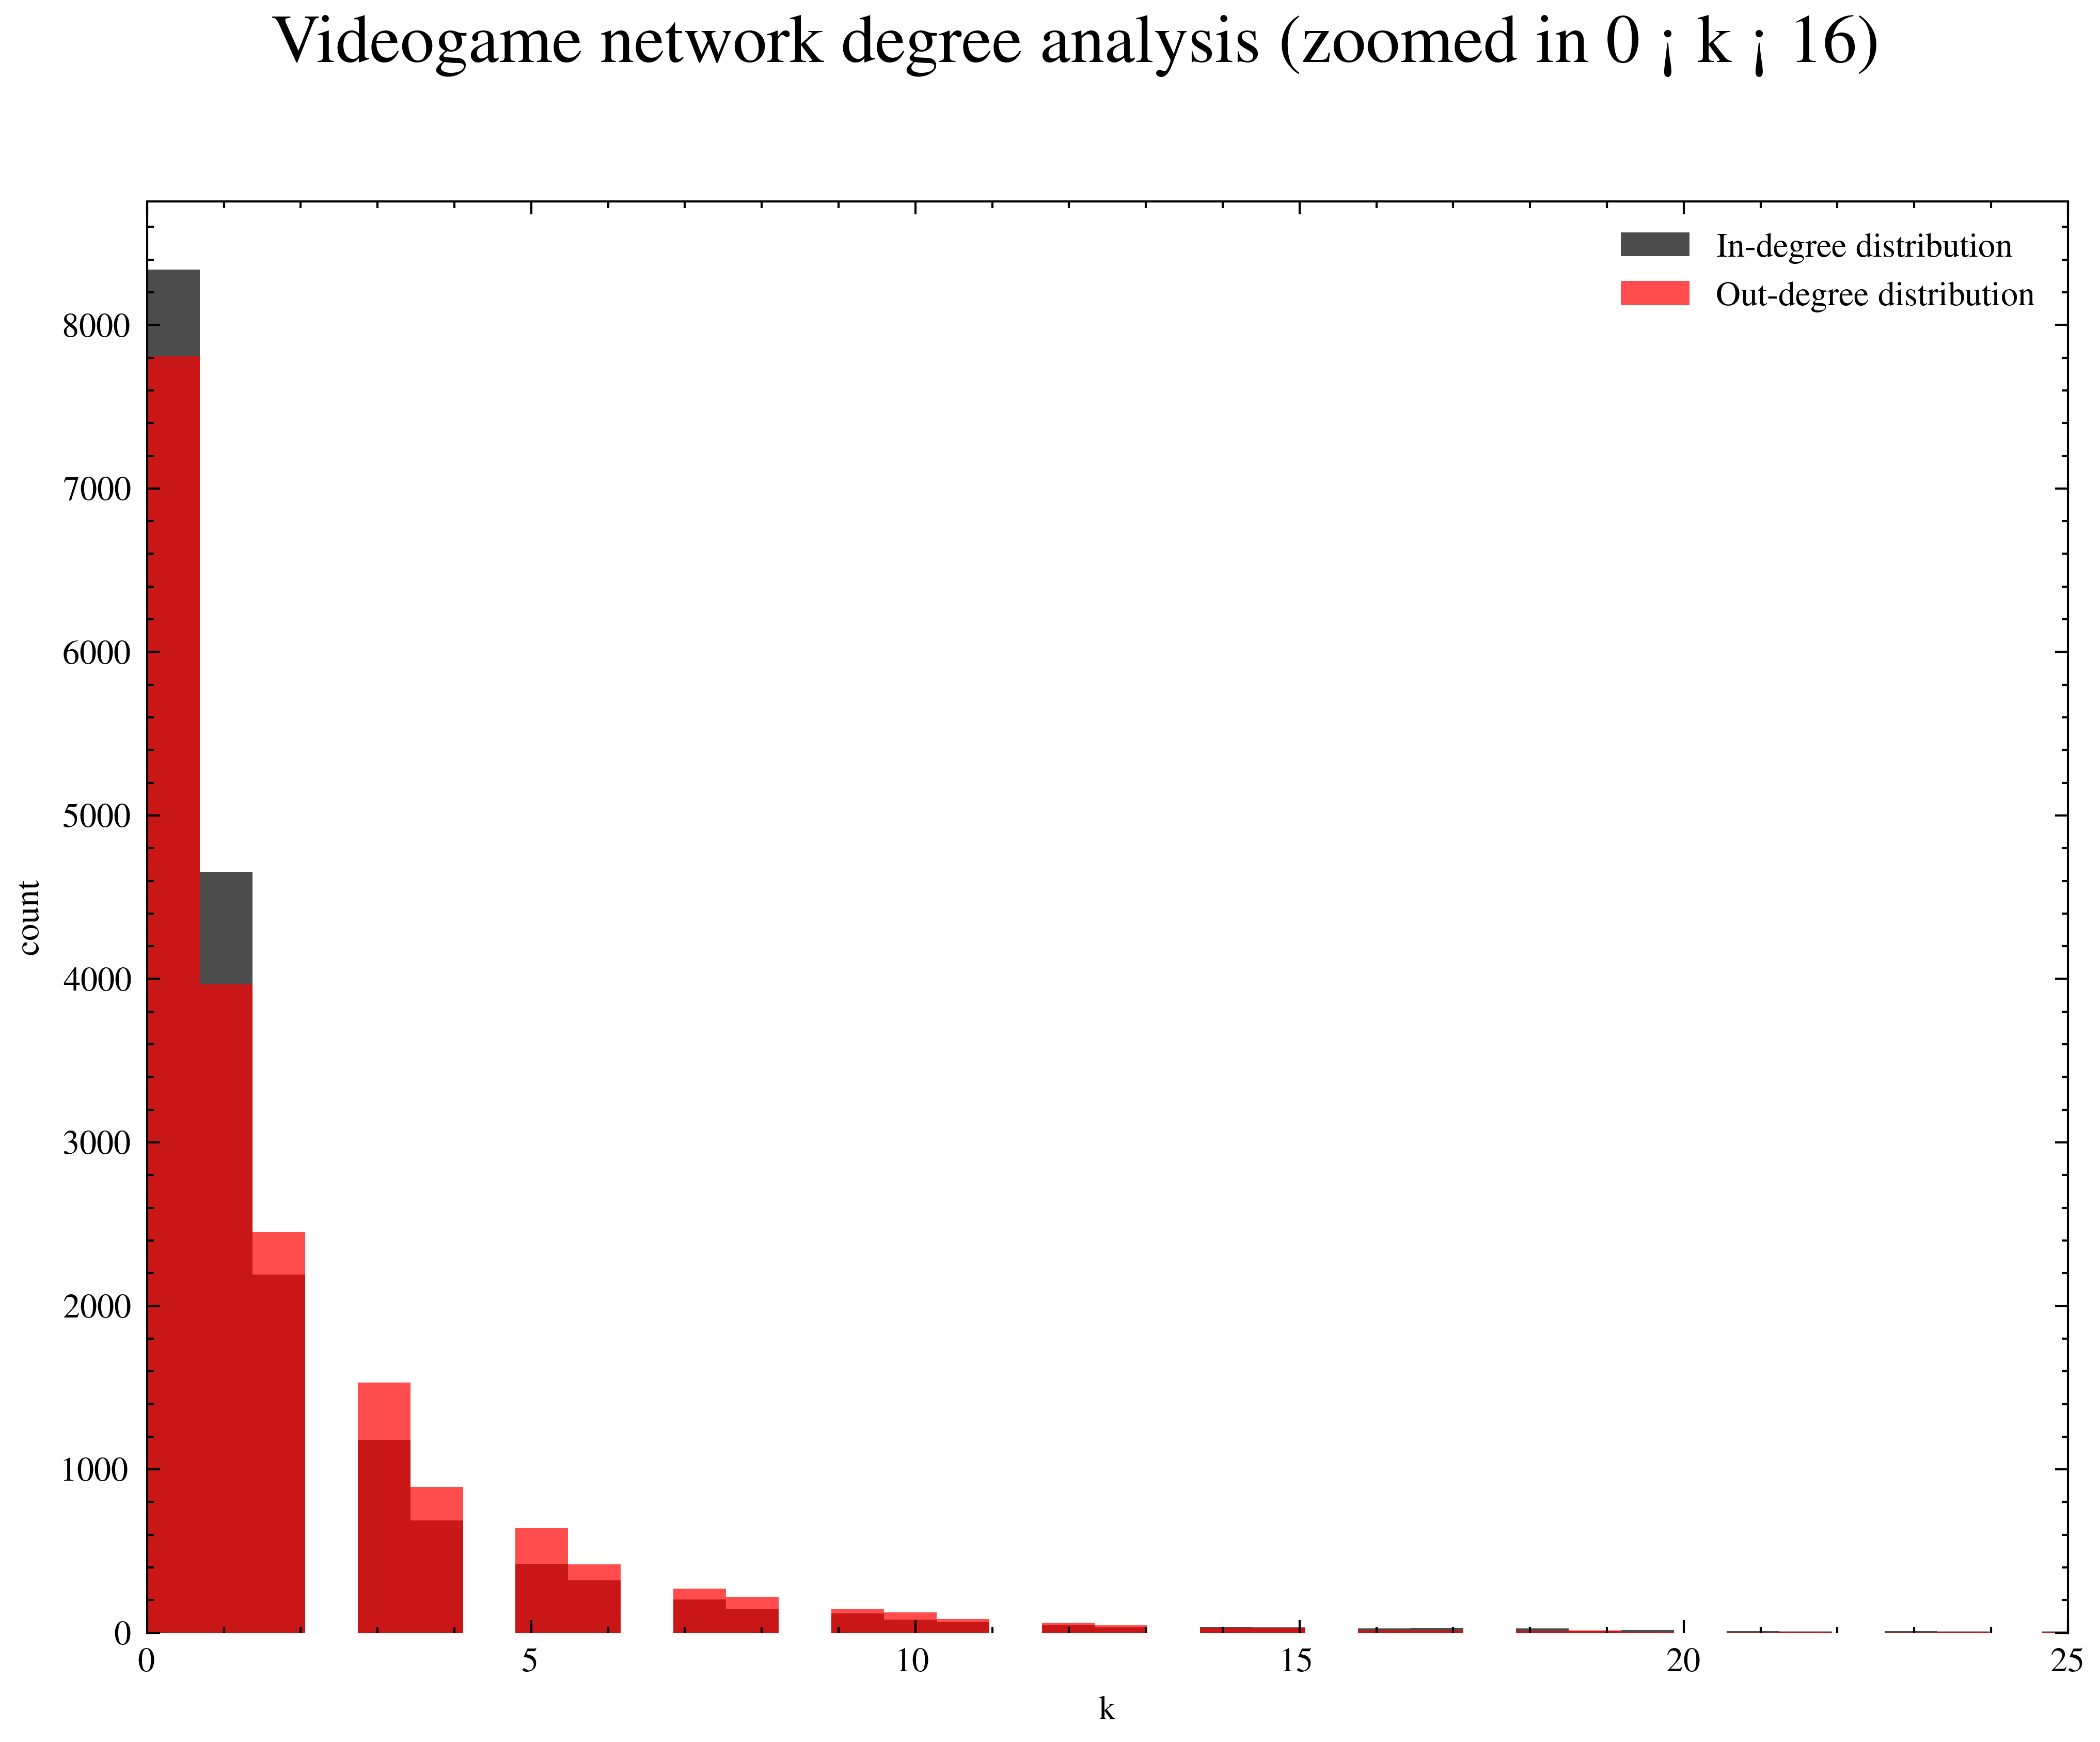

In [17]:
fig, (ax1) = plt.subplots(1, 1)

# Compare each plot
bins = degree_distribution_plot(dict(G.in_degree).values(), "In-degree distribution", 
    dict(G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis (zoomed in 0 < k < 16)', n_bins=250, figsize=(8,6), fig = fig, ax=ax1
    # , xscale="log", yscale="log"
    )

cut = 40
in_scatter = [d for d in dict(G.in_degree).values() if d > cut]
out_scatter = [d for d in dict(G.out_degree).values() if d > cut]
ax1.scatter(in_scatter, [0.5]*len(in_scatter), marker='+', color='tab:blue', alpha=0.7)
ax1.scatter(out_scatter, [0.5]*len(out_scatter), marker='x', color='tab:orange', alpha=0.7)
ax1.set_xlim(0, 25)

In [4]:
import pandas as pd

all_names = pd.read_csv("../all_page_names.csv")

len(all_names["Page Names"]) ,len(set(all_names["Page Names"])) # some games names are repeated curios! 

(27362, 26720)

In [5]:
# Visualize graph
import networkx as nx
# pos = nx.spring_layout(G)
# nx.draw(G)
# plt.show()

In [6]:
# Maybe we need this
import powerlaw

fit = powerlaw.Fit(degree_sequence)
alpha = fit.power_law.alpha

print(f"Estimated Power-Law Exponent (alpha): {alpha}")

Calculating best minimal value for power law fit
Estimated Power-Law Exponent (alpha): 3.337340469738638


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [7]:
from math import log

connected = False
k_avg = sum(dict(G.degree()).values()) / len(G)

print(f"<k>={k_avg} & ln(N)={log(num_nodes)}")

response = ""

if 0 < k_avg < 1:
    response += "The network is in the subcritical regime "
elif k_avg == 1:
    response += "The network is in the critical point regime "
elif k_avg > 1:
    response += "The network is in the supercritical regime"
elif k_avg > log(num_nodes):
    response += "The network is in the connected regime"
response +=  "and is not connected."
print(response)

<k>=3.3515718562874253 & ln(N)=10.193167627650581
The network is in the supercritical regimeand is not connected.


In [8]:
sorted([(n, d) for n, d in G.in_degree()], key= lambda x: x[1], reverse=True)

[('Pac-Man', 237),
 ('Tetris', 187),
 ('Arcade Archives', 140),
 ('Myst', 136),
 ('Super Mario Bros.', 133),
 ('Street Fighter II', 122),
 ('Space Invaders', 119),
 ('Super Smash Bros. Ultimate', 119),
 ('Minecraft', 104),
 ('Final Fantasy VII', 95),
 ('World of Warcraft', 94),
 ('Galaxian', 88),
 ('Super Mario 64', 86),
 ('Half-Life 2', 82),
 ('Xevious', 77),
 ('R-Type', 73),
 ('Galaga', 68),
 ('Dig Dug', 68),
 ('Pong', 67),
 ('Frogger', 67),
 ('Space Harrier', 66),
 ('Out Run', 66),
 ('Super Smash Bros. Brawl', 64),
 ('Team Fortress 2', 63),
 ('Wolfenstein 3D', 58),
 ('Resident Evil 4', 56),
 ('Arkanoid', 55),
 ('BioShock', 55),
 ('Donkey Kong Country', 53),
 ('Super Mario World', 53),
 ('Chrono Trigger', 53),
 ('Final Fantasy Tactics', 52),
 ('Super Mario Bros. 3', 49),
 ('League of Legends', 48),
 ('Grand Theft Auto III', 47),
 ('Bubble Bobble', 46),
 ('Pole Position', 45),
 ("Sonic's Ultimate Genesis Collection", 45),
 ('Sonic the Hedgehog 2', 45),
 ('Final Fantasy X', 45),
 ('Ms.

In [10]:
import os
import json
from collections import Counter
from tqdm import tqdm
import pickle

directory_path = './data'
categories_counter_file = 'categories_counter.pkl'

# Function to save the counter to a file
def save_counter(counter, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(counter, f)

# Function to load the counter from a file
def load_counter(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Check if the categories counter file exists and load it, otherwise create a new counter
if os.path.exists(categories_counter_file):
    categories_counter = load_counter(categories_counter_file)
else:
    categories_counter = Counter()
    for subdir, dirs, files in os.walk(directory_path):
        for file in tqdm(files, desc="Processing Files"):
            if file.endswith(".json"):
                filepath = os.path.join(subdir, file)
                with open(filepath, 'r', encoding='utf-8') as json_file:
                    data = json.load(json_file)
                    categories = data.get('categories', [])
                    categories_counter.update(categories)
    # Save the counter to a file after processing all files
    save_counter(categories_counter, categories_counter_file)

# Print the entire counter or the count for a specific category
print(categories_counter)
# Example: printing the count for "Windows games"
print(f"The 'Windows games' category appears {categories_counter['Windows games']} times.")



Processing Files: 0it [00:00, ?it/s]
Processing Files: 100%|██████████| 1/1 [00:00<00:00, 111.08it/s]

Counter({'Windows games': 10963, 'Single-player video games': 8679, 'Video games developed in the United States': 8386, 'Multiplayer and single-player video games': 8224, 'Video games developed in Japan': 7804, 'Video games developed in the United Kingdom': 3739, 'PlayStation 4 games': 3070, 'MacOS games': 2726, 'IOS games': 2722, 'Windows-only games': 2533, 'Nintendo Switch games': 2530, 'DOS games': 2416, 'PlayStation 2 games': 2305, 'Xbox One games': 2300, 'Video game sequels': 2294, 'Android (operating system) games': 2005, 'Video games featuring female protagonists': 2005, 'Arcade video games': 1931, 'Japan-exclusive video games': 1847, 'PlayStation 3 games': 1800, 'Role-playing video games': 1766, 'Commodore 64 games': 1752, 'Indie games': 1732, 'PlayStation (console) games': 1683, 'Xbox 360 games': 1634, 'Amiga games': 1608, 'Linux games': 1579, 'Platformers': 1478, 'Science fiction video games': 1476, 'PlayStation Network games': 1475, 'Adventure games': 1431, 'Action-adventure

In [14]:
sum([item  for key,item in categories_counter.items() if key.startswith("Video games developed in")])
[(key, item)  for key,item in categories_counter.items() if key.startswith("Video games developed in")]

[('Video games developed in Canada', 1248),
 ('Video games developed in the United Kingdom', 3739),
 ('Video games developed in the United States', 8386),
 ('Video games developed in Poland', 244),
 ('Video games developed in Japan', 7804),
 ('Video games developed in Germany', 582),
 ('Video games developed in Sweden', 389),
 ('Video games developed in Taiwan', 84),
 ('Video games developed in New Zealand', 54),
 ('Video games developed in France', 852),
 ('Video games developed in Australia', 442),
 ('Video games developed in Italy', 181),
 ('Video games developed in Spain', 207),
 ('Video games developed in Hungary', 108),
 ('Video games developed in Belgium', 42),
 ('Video games developed in the Netherlands', 184),
 ('Video games developed in the Czech Republic', 202),
 ('Video games developed in Finland', 214),
 ('Video games developed in Russia', 268),
 ('Video games developed in Ireland', 35),
 ('Video games developed in Croatia', 45),
 ('Video games developed in Serbia', 16),
 

In [12]:
categories_counter

Counter({'Windows games': 10963,
         'Single-player video games': 8679,
         'Video games developed in the United States': 8386,
         'Multiplayer and single-player video games': 8224,
         'Video games developed in Japan': 7804,
         'Video games developed in the United Kingdom': 3739,
         'PlayStation 4 games': 3070,
         'MacOS games': 2726,
         'IOS games': 2722,
         'Windows-only games': 2533,
         'Nintendo Switch games': 2530,
         'DOS games': 2416,
         'PlayStation 2 games': 2305,
         'Xbox One games': 2300,
         'Video game sequels': 2294,
         'Android (operating system) games': 2005,
         'Video games featuring female protagonists': 2005,
         'Arcade video games': 1931,
         'Japan-exclusive video games': 1847,
         'PlayStation 3 games': 1800,
         'Role-playing video games': 1766,
         'Commodore 64 games': 1752,
         'Indie games': 1732,
         'PlayStation (console) games': 

In [3]:
import os
import json
import mwparserfromhell

def parse_wiki_text_to_sections(wiki_text):
    # Parse the text with mwparserfromhell
    wikicode = mwparserfromhell.parse(wiki_text, skip_style_tags=True)
    
    sections_dict = {}
    current_section = 'introduction'
    sections_dict[current_section] = ''  # Initialize the intro section

    # Iterate through the parsed wiki code
    for node in wikicode.nodes:
        if isinstance(node, mwparserfromhell.nodes.heading.Heading):
            # When we find a heading, set the current section to the heading's title
            current_section = str(node.title).strip().lower()
            sections_dict[current_section] = ''
        else:
            # Otherwise, append the text of this node to the current section
            sections_dict[current_section] += str(node)

    # Clean up text for each section
    for section, text in sections_dict.items():
        # Remove references and other unwanted parts
        text = mwparserfromhell.parse(text).strip_code()
        sections_dict[section] = text

    return sections_dict

def load_json_data_to_dict(base_directory):
    all_data = {}  # Dictionary to hold all data from JSON files, keyed by the title
    for subdir, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.json'):
                filepath = os.path.join(subdir, file)
                with open(filepath, 'r', encoding='utf-8') as json_file:
                    data = json.load(json_file)
                    data["text"] = parse_wiki_text_to_sections(data["text"])
                    # Use the title as the key for the dictionary
                    all_data[data['title']] = data
    return all_data

# Replace with the actual path to your data directory
base_directory = './data'  # Update with the actual path
data_file = 'game_data.json'

if os.path.exists(data_file):
    with open(data_file) as f:
        json_data_dict = json.load(f)
else:
    json_data_dict = load_json_data_to_dict(base_directory)
    with open('game_data.json', 'w', encoding='utf-8') as json_file:
        json.dump(json_data_dict, json_file, ensure_ascii=False, indent=4)


# Now you can access the data for each game by its title, for example:
# game_data = json_data_dict['Highnoon']


KeyboardInterrupt: 

In [ ]:
json_data_dict["Warhammer 40,000: Battlesector"]["text"]


{'introduction': "Warhammer 40,000: Battlesector is a turn-based tactics video game developed by Black Lab Games and published by Slitherine Software for Windows on July 15, 2021. It is based on Games Workshop's tabletop wargame Warhammer 40,000.",
 'gameplay': 'Warhammer 40,000: Battlesector is a turn-based tactics game, played on a grid-based map with 10-25 units sized armies. A 20-mission single-player campaign centres on the Blood Angels fighting Tyranids on the moon Baal Secundus. There is player versus player multiplayer, either via online, hotseat, or play-by-mail methods.',
 'release': 'Battlesector was announced on February 9, 2021, for a release in May 2021. Console versions for PlayStation 4 and Xbox One were due for summer 2021. On May 11, 2021, the game was delayed to mid-July 2021. The game was released for Windows on July 22, 2021. On November 15, 2021, the console versions were delayed to December 2, 2021. Two major downloadable content (DLC) packs were released for the

NameError: name 'json_data_dict' is not defined